D:\Anaconda\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Anaconda\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


R^2 = 0.70


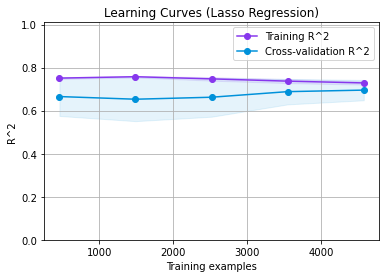

In [1]:
# 資料處理套件
import pandas as pd

# 讀取資料
df_car = pd.read_csv('1_Car_Curb_Weight_Training.csv') 
df_truck = pd.read_csv('1_Truck_Curb_Weight_Training.csv') 

df_combined = pd.concat([df_car, df_truck], ignore_index=True)

# ML套件
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def kmeans_(df):
    included = ['Engine Size(L)', 'Cylinders', 'weight']
    X = df[included]

    model = KMeans(n_clusters=5, n_init='auto', random_state=1)
    model.fit(X)
    
    df['Cluster'] = model.labels_
    
    return df

df_combined = kmeans_(df_combined)

def first_step_training(df):
    X = df[['Engine Size(L)', 'Cylinders','Cluster', 'weight']]
    y = df['CO2 Emissions(g/km)']
    
    model = Lasso(alpha=1.0)  # You can adjust the alpha parameter based on your needs
    
    model.fit(X, y)
    
    y_pred = model.predict(X)
    
    X_filtered = df[['Engine Size(L)', 'Cylinders','Cluster', 'weight']]
    y_filtered = df['CO2 Emissions(g/km)']
    
    return model, X_filtered, y_filtered

def second_step_training(model, X_filtered, y_filtered):
    # Lasso model does not require a second step with studentized data
    return model

lasso_model, X_filtered, y_filtered = first_step_training(df_combined)
final_model = second_step_training(lasso_model, X_filtered, y_filtered)

def plot_learning_curve_r2(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='r2', n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="#8737ED")  # Purple color
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#0091DA")  # Blue color
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#8737ED",  # Purple color
             label="Training R^2")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#0091DA",  # Blue color
             label="Cross-validation R^2")

    # Get the rightmost point
    rightmost_point = (train_sizes[-1], test_scores_mean[-1])
    print(f'R^2 = {rightmost_point[1]:.2f}')

    plt.legend(loc="best")
    return plt

title_second_stage = "Learning Curves (Lasso Regression)"
plot_learning_curve_r2(final_model, title_second_stage, X_filtered, y_filtered, cv=5, ylim=(0.0, 1.01), n_jobs=1)

plt.show()
